
# How to check all possible target binding sites against off-target binding sites in whole transcriptome
We have a target mRNA that we want to bind with RNA binding proteins. To design these pumby proteins we need to select binding sites on our target mRNA which are very unique, i.e. ideally dont occure elsewhere the transcriptome.  Or more general: We have a target sequence and we want to find a subsequence of specified length which is as specific to this target as possible i.e. has the least interactions with dataset of reference sequences. 

**This notebook is focused on testing and building up step by step the basic algorithm using random sequences.** To see the algorithm applied to real sequences see the "main" notebook.

In [1]:
from IPython.core.magic import register_cell_magic, register_line_magic

@register_cell_magic
def run_and_writefile(line, cell): # adapted from andrei-iatsuk copied from https://stackoverflow.com/questions/33358611/ipython-notebook-writefile-and-execute-cell-at-the-same-time
    argz = line.split()
    file = argz[-1]
    mode = 'a'
    if len(argz) == 2 and argz[0] == '-w':
        mode = 'w'
    content = cell[:cell.find("%stop_write")] + "\n\n"
    with open(file, mode) as f:
        f.write(content)
    get_ipython().run_cell(cell)

@register_line_magic
def stop_write(line):
    pass

In [2]:
%%run_and_writefile -w main_search.py

import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import pandas as pd

%stop_write

import warnings
from joblib import Parallel, delayed
from tqdm import tqdm
import pathlib
from IPython.display import display

In [3]:
%%run_and_writefile main_search.py

@njit  # just in time compilation speeds up sequence comparison, also see seq_compare_runtime file
def sc_jit(seq:bytes|str, ref:bytes|str):
    '''A fast Sequence Comparison of a short query sequence (seq) against a larger reference (ref).
    Returns the number of matches for every position the sort sequence could bind to the larger one. Consideres only full overlap binding, i.e. no overhangs '''

    n = len(ref) - len(seq) + 1
    if n<1: print("sc_jit: wrong argument order")
    cv = np.zeros(n, dtype=np.uint16) 
    for i in range(n):
        WEIGHT = 0
        for j in range(len(seq)):
            if ref[i + j] == seq[j]:
                WEIGHT += 1
        cv[i] = WEIGHT
    return cv
    
def random_seq(size:int):
    '''returns a random ACGT sequence of length = size'''
    return ''.join(np.array(["A", "C", "G", "T"])[np.random.randint(low = 0, high = 4, size = size)])

sc_jit(random_seq(10), random_seq(10));    # call it once so that numba compiles it

%stop_write main_search.py

print("with string encoding \t ", end = "")
%timeit sc_jit(random_seq(10).encode(), random_seq(10).encode())
print("without string encode \t ", end = "")

%timeit sc_jit(random_seq(10), random_seq(10))


with string encoding 	 24.5 μs ± 230 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
without string encode 	 30.6 μs ± 907 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


 <br>

# Search for off-target binding-sites on single transcript 
= global sequence comparison of query with a reference sequence
- as we are searching for binding sites in the transcriptome, we'd ideally find as few as possible to avoid unwanted side-effects.
- As the binding sites are usually shorter then the persistence length of the polymers, a global sequence alignment search should suffice (we dont need BLAST)

In [4]:
query = pd.Series({"SEQ_NAME": "rand_candidate",  "SEQUENCE": random_seq(size = 6)})        # the query sequence i.e. a candidate binding sequence for the target 
ref   = pd.Series({"SEQ_NAME": "rand_transcript", "SEQUENCE": random_seq(size = 1200)})     # The reference to check against, i.e. a transcript from the transcriptome in this example
# instead of the name being the variable name and the sequence its value, this more approach is choses as is nicely generalises to lists of querys and lists of references which can be stored as pandas.DataFrames

display(pd.DataFrame([query, ref]) )

,SEQ_NAME,SEQUENCE
0,rand_candidate,AGGAAA
1,rand_transcript,AGCACTGTAGCGCTTAGCGACCTGTCCCCACTGAACGATTAAAGGA...


{'mismatch_eq_0': np.int64(0), 'mismatch_eq_1': np.int64(6), 'mismatch_eq_2': np.int64(49), 'boltzmann factor': np.float64(2.274360589024245)}


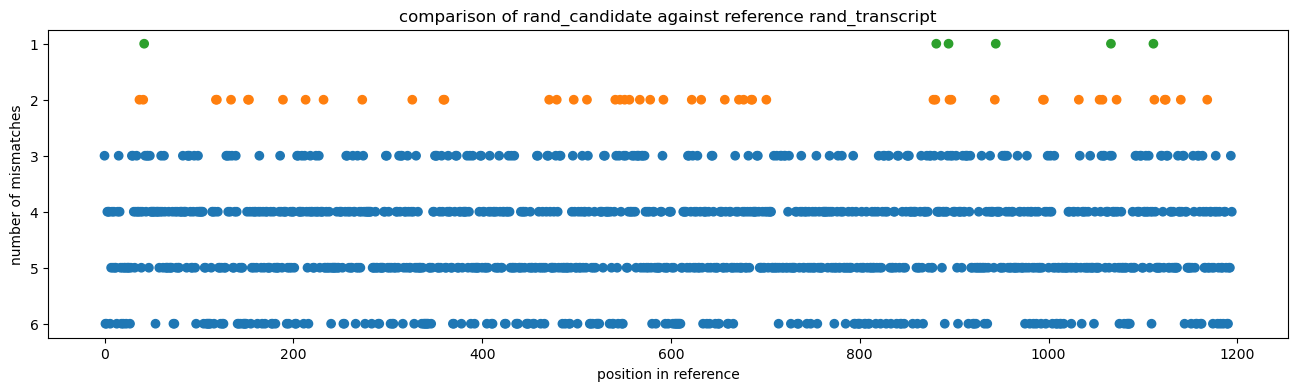

In [5]:

mm = len(query.SEQUENCE)-sc_jit(query.SEQUENCE.encode(), ref.SEQUENCE.encode()) # mm = number of mismatches at each possible binding position; encoding strings into bytes is faster for some reason; sc_jit returns the number of matches thats why mm = len - sc

sc_results = {}  # summarize the possible binding sites of the query sequence against one reference sequence i.e. a transcript from the transcriptome
sc_results["mismatch_eq_0"] = (mm==0).sum()                  # number of idential matches
sc_results["mismatch_eq_1"] = (mm==1).sum()                  # number of matches with 1 mismatch
sc_results["mismatch_eq_2"] = (mm==2).sum()                  # number of matches with 2 mistmatches
sc_results["boltzmann factor"] = np.sum(np.exp(-2.0*mm))     # a very basic prediction of how likely the query sequence would bind to the reference. The wildtype pumilios have ~ 18 hydrogen bonds for 8nt i.e. 2.25 hydgrogen bonds = 2.25kT per bp, however the pumby appears to only have ~2 H-bonds per bp, and the binding statistics suggest closer to 1kT -> lets go with 1.5 for now, in the future a more accurate model might be implemented. Currently the boltzmann_factor for a perfect match is 1, if therefore this predicted boltzmann_factor is smaller than 1 than it is more likly to bind to the specific RNA, while if it is larger than one it is more likely to bind to the background transcriptom 

if True:       
    plt.figure(figsize=(16, 4))
    plt.scatter(np.arange(mm.size), mm, c = np.array(["tab:red", "tab:green", "tab:orange", "tab:blue"])[np.clip(mm, 0, 3)])
    plt.gca().invert_yaxis()
    plt.ylabel("number of mismatches")
    plt.xlabel(f"position in reference")
    plt.title(f"comparison of {query.SEQ_NAME} against reference {ref.SEQ_NAME}")

print(sc_results)

<br>  

# Search for off-target binding-sites in a dataset of transcripts
= compare a query to a dataset of reference sequences

In [6]:
# generate random input sequences for this test
transcriptom = pd.DataFrame([{"SEQ_NAME": f"random_transcript_#{i:04d}", "SEQUENCE": random_seq(size = 1200), "WEIGHT": (np.random.poisson(5))**3 / 205} for i in range(7000)])      # The references to check against, i.e. the transcriptome in this example
target       = pd.Series(    {"SEQ_NAME": "random_target",               "SEQUENCE": random_seq(size = 800),   "WEIGHT": 1})                                        # The sequence from which we want ot find the best/unique binding site


In [7]:
# specify parameters
query_len = 10        # length of the binding sites (usually 8-12 for pumby)
plot = True                  # whether to show plots


# add the target itself to the dataset to check against
reference_dataset = pd.concat([pd.DataFrame([target]), transcriptom], axis = 0)  

# generate dataset of all possible binding sequences
query_dataset = pd.DataFrame([{"SEQ_NAME": target.SEQ_NAME + f"_{k:03d}:{k+query_len:03d}", "SEQUENCE":target.SEQUENCE[k:k+query_len],  "WEIGHT": target.WEIGHT} for k in range(len(target.SEQUENCE)-query_len)] )

# pick a random binding site candidate for this test
query = query_dataset.sample().iloc[0]  
print(query)

SEQ_NAME    random_target_223:233
SEQUENCE               GCTGATAAAC
WEIGHT                          1
Name: 223, dtype: object


In [8]:
#-------------------------------------------------#
#              input arguments check              #  -> checks if the parameters have expected datatype to prevent errors later on
#-------------------------------------------------#

# check data types
if not type(reference_dataset) == pd.DataFrame: raise TypeError("unsupported type for 'reference_dataset', use pandas.DataFrame")
if not ("SEQ_NAME" in reference_dataset.columns and "SEQUENCE" in reference_dataset.columns):
    raise TypeError ('reference_dataset does not contain required columns: SEQ_NAME, SEQUENCE')
if type(query) == pd.Series:  pass # everything is fine
elif type(query) == str:           # convert to pandas series
    warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")
    query = pd.Series({"SEQ_NAME": "unnamed", "SEQUENCE": query})
elif type(query) == pd.DataFrame and len(query) == 1:
    warnings.warn("Warning, query had to be converted from pandas.DataFrame to pandas.Series!")
    query = query.iloc[0]
else: raise TypeError("unsupported type for 'query', use pandas.Series")

# check how many different nucleotides occure in the provided sequences
if len(set(reference_dataset.SEQUENCE.sample(100).sum()) | set(reference_dataset.SEQUENCE.iloc[:10].sum()) | set(reference_dataset.SEQUENCE.iloc[-10:].sum())) != 4: 
    warnings.warn(f"Warning, expected 4 types of nucleoties in the input, found (at least) {len(nts)}")

In [9]:
#-------------------------------------------------#
#  Search for binding sites in reference dataset  #
#-------------------------------------------------# 
sc_results = []                                                          # initialize a dataset to store the results of comparing query sequence with every reference i.e. every transcript in the transcriptome
for i, ref in reference_dataset.iterrows():                              # iterate over all reference sequences; and the target itself as control 
    
    # check how many different nucleotides occure in the provided sequences
    if len(set(ref.SEQUENCE) | set(query.SEQUENCE) ) != 4: warnings.warn(f"Warning, expected 4 types of nucleoties in the input, found (at least) {len(nts)}")

    # number of mismatches per position  = length - number of matches. I dunno why but its faster in bytes
    if type(query.SEQUENCE) == str:     mm = len(query.SEQUENCE)-sc_jit(query.SEQUENCE.encode(), ref.SEQUENCE.encode())    
    elif type(query.SEQUENCE) == bytes: mm = len(query.SEQUENCE)-sc_jit(query.SEQUENCE, ref.SEQUENCE)      

    sc_row = {}                                                          # create dictionary to summarize the possible binding sites of the query sequence against one reference sequence (here a transcript). sc = sequence compare
    sc_row["identical match"]  = (mm==0).sum()                           # number of idential matches
    sc_row["1nt mismatch"]     = (mm==1).sum()                           # number of sites with 1 mismatch
    sc_row["2nt mismatch"]     = (mm==2).sum()                           # number of sites with 2 mismatch
    sc_row["boltzmann factor"] = np.sum(np.exp(-2*mm.astype(float)))     # exp(energy) with energy ~ 2kt * mm is a very basic prediction of how likely the query sequence would bind to the reference. The wildtype pumilios have ~ 18 hydrogen bonds for 8nt i.e. 2.25 hydgrogen bonds = 2.25kT per bp, however the pumby appears to only have ~2 H-bonds per bp, and the binding statistics suggest closer to 1kT -> lets go with 1.5 for now, in the future a more accurate model might be implemented. Currently the boltzmann_factor for a perfect match is 1, if therefore this predicted boltzmann_factor is smaller than 1 than it is more likly to bind to the specific RNA, while if it is larger than one it is more likely to bind to the background transcriptom. The float conversion is there because pandas does not like float16 only float32 and larger, for some reason without this explicit astype it would be float16 
    sc_results.append(sc_row)                                            # add the sequence comparison summary for this reference (here transcript) to the dataset
sc_results = pd.concat([reference_dataset, pd.DataFrame(sc_results, reference_dataset.index)], axis = 1)   # convert to pandas dataframe and add original columns 

display(sc_results)

,SEQ_NAME,SEQUENCE,WEIGHT,identical match,1nt mismatch,2nt mismatch,boltzmann factor
0,random_target,TTTCCTAGGGTACATGGGCCGTCGTCTGGCGCCGAGCATCTACGGG...,1.000000,1,0,0,1.016131
0,random_transcript_#0000,GCAAACTCGGGCTGAACCAAGTTCTACTACGCAAACGTTCTATTGT...,0.312195,0,0,0,0.024717
1,random_transcript_#0001,ATACTCATCATTCACAATCGATTCAGGCTGGTTACTAAGTGCTAGC...,0.131707,0,0,0,0.020117
2,random_transcript_#0002,TGGACTCTTTGATAGAGTAATGTAGGTAGTACATAGTTGCTTTTGT...,0.312195,0,0,0,0.014370
3,random_transcript_#0003,AACCAGGGCGATCTCCCAAACATAGGCGACCAAGCATTGAGGCACT...,1.053659,0,0,1,0.032592
...,...,...,...,...,...,...,...
6995,random_transcript_#6995,AGTGGGCCGGGAAACCAACGTAATGCAAATCGAGGGGGGTCAGTTG...,1.673171,0,0,1,0.036354
6996,random_transcript_#6996,CAATTGGAGCAGCAACGTATCACGCCCGGATATCTTGCACCCATCG...,0.131707,0,0,2,0.059680
6997,random_transcript_#6997,CCAACAAGCAAAGGGTGTGGTTGACTAAGTGAGGCCGTTGGCTCGG...,0.312195,0,0,0,0.019841
6998,random_transcript_#6998,CGTACCCCTTGAGGCATTCCACGCCCGGCGGTGGTGCCTCCTGGTG...,3.556098,0,0,0,0.019119


In [10]:
%%run_and_writefile main_search.py

def query_sc(query:pd.Series, reference_dataset:pd.DataFrame)->pd.DataFrame:
    '''searches for (partial) matches between query sequence and reference dataset
    query: sequence to be found (pd.Series object)
    reference_dataset: pd.DataFrame of sequences to test against
    Both need at least a SEQ_NAME and a SEQUENCE column
    Returns copy of reference_dataset with new columns containing the results
    '''
    #-------------------------------------------------#
    #              input arguments check              #  -> checks if the parameters have expected datatype to prevent errors later on
    #-------------------------------------------------#

    # check data types
    if not type(reference_dataset) == pd.DataFrame: raise TypeError("unsupported type for 'reference_dataset', use pandas.DataFrame")
    if not ("SEQ_NAME" in reference_dataset.columns and "SEQUENCE" in reference_dataset.columns):
        raise TypeError('reference_dataset does not contain required columns: SEQ_NAME, SEQUENCE')
    if type(query) == pd.Series:  pass # everything is fine
    elif type(query) == str:           # convert to pandas series
        warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")
        query = pd.Series({"SEQ_NAME": "unnamed", "SEQUENCE": query})
    elif type(query) == pd.DataFrame and len(query) == 1:
        warnings.warn("Warning, query had to be converted from pandas.DataFrame to pandas.Series!")
        query = query.iloc[0]
    else: raise TypeError("unsupported type for 'query', use pandas.Series")

    # check how many different nucleotides occure in the provided sequences
    if len(set(reference_dataset.SEQUENCE.sample(100).sum()) | set(reference_dataset.SEQUENCE.iloc[:10].sum()) | set(reference_dataset.SEQUENCE.iloc[-10:].sum())) != 4: 
        warnings.warn(f"Warning, expected 4 types of nucleoties in the input, found (at least) {len(nts)}")

    #-------------------------------------------------#
    #  Search for binding sites in reference dataset  #
    #-------------------------------------------------# 
    sc_results = []                                                          # initialize a dataset to store the results of comparing query sequence with every reference i.e. every transcript in the transcriptome
    for i, ref in reference_dataset.iterrows():                              # iterate over all reference sequences; and the target itself as control 
        
        # check how many different nucleotides occure in the provided sequences
        if len(set(ref.SEQUENCE) | set(query.SEQUENCE) ) != 4: warnings.warn(f"Warning, expected 4 types of nucleoties in the input, found (at least) {len(nts)}")

        # number of mismatches per position  = length - number of matches. I dunno why but its faster in bytes
        if type(query.SEQUENCE) == str:     mm = len(query.SEQUENCE)-sc_jit(query.SEQUENCE.encode(), ref.SEQUENCE.encode())    
        elif type(query.SEQUENCE) == bytes: mm = len(query.SEQUENCE)-sc_jit(query.SEQUENCE, ref.SEQUENCE)      

        sc_row = {}                                                          # create dictionary to summarize the possible binding sites of the query sequence against one reference sequence (here a transcript). sc = sequence compare
        sc_row["identical match"]  = (mm==0).sum()                           # number of idential matches
        sc_row["1nt mismatch"]     = (mm==1).sum()                           # number of sites with 1 mismatch
        sc_row["2nt mismatch"]     = (mm==2).sum()                           # number of sites with 2 mismatch
        sc_row["boltzmann factor"] = np.sum(np.exp(-2*mm.astype(float)))     # exp(energy) with energy ~ 2kt * mm is a very basic prediction of how likely the query sequence would bind to the reference. The wildtype pumilios have ~ 18 hydrogen bonds for 8nt i.e. 2.25 hydgrogen bonds = 2.25kT per bp, however the pumby appears to only have ~2 H-bonds per bp, and the binding statistics suggest closer to 1kT -> lets go with 1.5 for now, in the future a more accurate model might be implemented. Currently the boltzmann_factor for a perfect match is 1, if therefore this predicted boltzmann_factor is smaller than 1 than it is more likly to bind to the specific RNA, while if it is larger than one it is more likely to bind to the background transcriptom. The float conversion is there because pandas does not like float16 only float32 and larger, for some reason without this explicit astype it would be float16 
        sc_results.append(sc_row)                                            # add the sequence comparison summary for this reference (here transcript) to the dataset
    sc_results = pd.concat([reference_dataset, pd.DataFrame(sc_results, reference_dataset.index)], axis = 1)   # convert to pandas dataframe and add original columns 

    return sc_results
    
%stop_write

%timeit query_sc(query_dataset.sample(1).iloc[0], reference_dataset)

694 ms ± 4.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


---------

### summarize sequence comparision data

In [11]:

# retrieve target and references results
references_scr = sc_results.loc[~(sc_results.SEQ_NAME == target.SEQ_NAME)].reset_index(drop = True)  # results from the comparison with the reference dataset (sqeuences to avoid)
_target_scr =     sc_results.loc[  sc_results.SEQ_NAME == target.SEQ_NAME ].reset_index(drop = True)  # results from the comparison with the target sequence
if len(_target_scr) > 1: raise IndexError("unexpected result, there should only be one entry")        # there should only be one entry for the target
else: target_scr = _target_scr.iloc[0]

# specify parameters for summary
use_weights = True           # whether to use WEIGHT column
VIR_max = 10                 # number of very important references per metric saved in the results 
r2t = True                   # if possible, normalize references results relative to target results

In [12]:
#-------------------------------------------------#
#              input arguments check              #  -> checks if the parameters have expected datatype to prevent errors later on
#-------------------------------------------------#

if type(references_scr) != pd.DataFrame: raise TypeError("unsupported type for 'references_scr', use pandas.DataFrame")

if use_weights:  # check if the input data is okay to use weighted evalutation
    if "WEIGHT" in references_scr.columns:
        invalid = references_scr.WEIGHT.isin([np.inf, -np.inf, np.nan])
        if invalid.any():  warnings.warn(f"{invalid.sum()} entries with nan or inf WEIGHT in references_scr. The script might not behave as intended.")
    else:   raise TypeError("references_scr: No WEIGHT column found, to switch to unweighted mode use use_weights = False")

if r2t:
    if type(target_scr) == pd.Series:  pass
    elif type(target_scr) == pd.DataFrame:  
        warnings.warn("Warning, query had to be converted from pandas.DataFrame to pandas.Series!")
        target_scr = target_scr.iloc[0]
    else: raise TypeError("unsupported type for 'target_scr', use pandas.Series")

    if use_weights:  # check if the input data is okay to use weighted evalutation
        if "WEIGHT" in target_scr:
            if target_scr.WEIGHT in [np.inf, -np.inf, np.nan]: warnings.warn(f"target_scr has nan or inf WEIGHT. The script might not behave as intended.")
        else:   raise TypeError("target_scr: No WEIGHT property found, to switch to unweighted mode use use_weights = False")


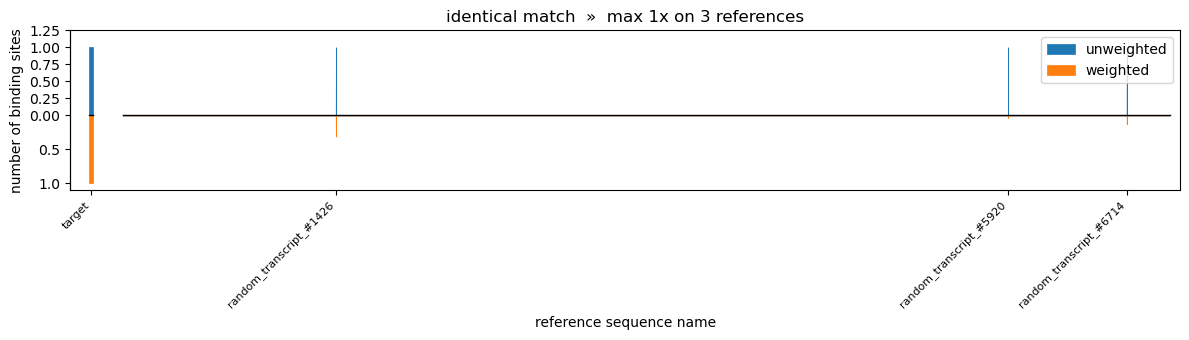

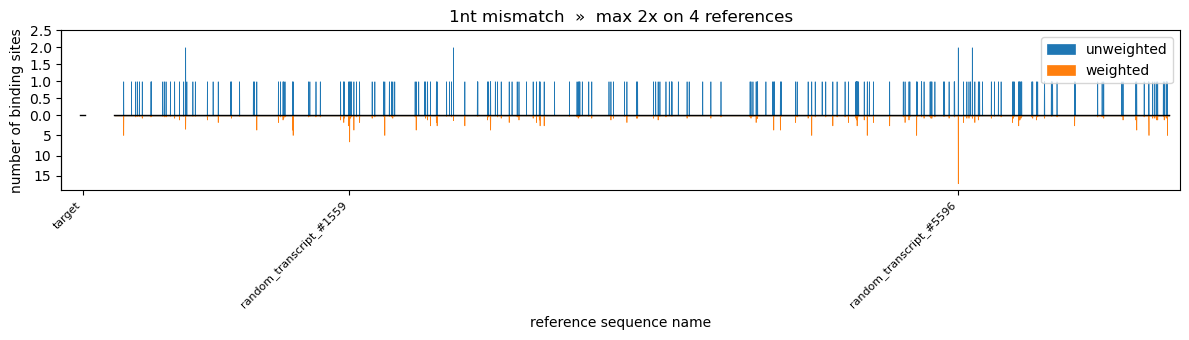

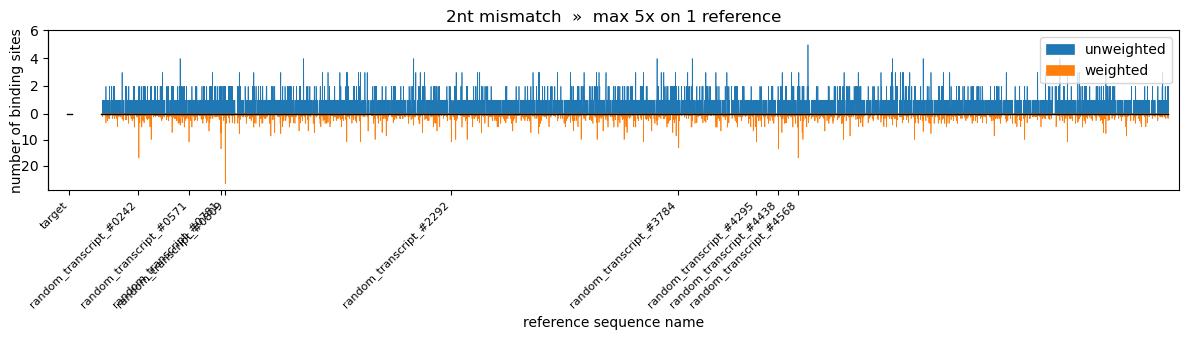

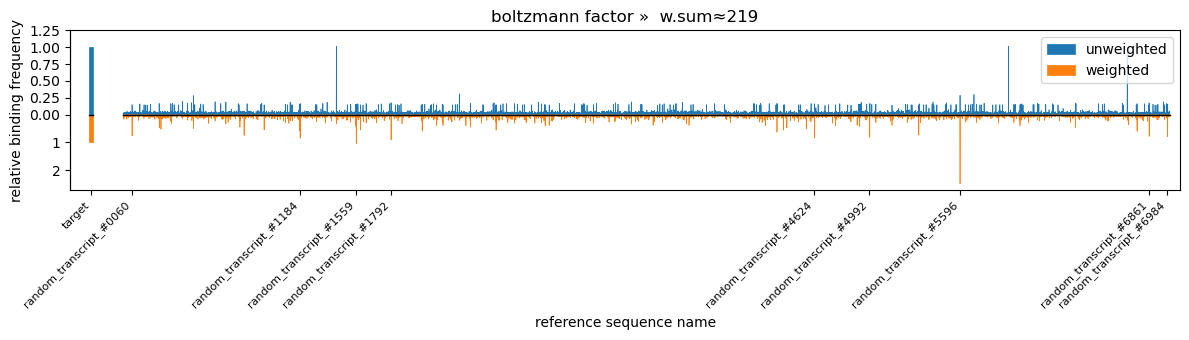

In [13]:


#-------------------------------------------------------#
# summarize interaction of query with reference dataset #   ->  now that we have a huge and detailed list of the interaction with every of the thousands of reference sequences (i.e. transcripts), we need to summarize again to only a few metrics telling how much this query sequence interacts with the references overall
#-------------------------------------------------------#

sc_summary = query.to_dict()
for i, metric in enumerate(["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]): # iterate over all the metrics that should be summarized

    ref_metric = references_scr[metric]         # results of comparing the query i.e. candidate sequence against the Reference dataset. metrics from references -> ref_metric
    if r2t: trg_metric = target_scr[metric]             # results of comparing the query i.e. candidate sequence against the Target sequence.   metrics from target   -> trg_metric
    if use_weights:   # weighted metric -> wetric
        ref_wetric = references_scr[metric] * references_scr["WEIGHT"]
        if r2t: trg_wetric = target_scr[metric] * target_scr["WEIGHT"]

    if "oltzman" in metric and r2t:               # for the Boltzmann factor it is compared to the Boltzmann factor of the query sequence --> relative comparison of query binding to the target vs transcripts
        insert = " r2t"; norm = trg_metric        # = "relative to target". used for column name
        if use_weights: norw = trg_wetric         # norw = normalization for weighted data
    else:  insert = "";   norm = 1;   norw = 1    # the mismatch count data is not re-normalized

    # summarize the sequence comparison results: sum = total number of binding sites, while max = maximum number of binding sites per reference sequence i.e. transcript
    sc_summary[ metric + f" max" + insert] = ref_metric.max() / norm        # What was the highest number of off-target binding sites on a single reference i.e. transcript
    sc_summary[ metric + f" sum" + insert] = ref_metric.sum() / norm        # What was the  total  number of off-target binding sites on the whole reference dataset i.e. transcriptome
    VIR_selec = ((ref_metric > sorted(ref_metric)[-min(VIR_max, len(ref_metric))]) | (ref_metric == ref_metric.max()) * (ref_metric != ref_metric.min())) ## (ref_metric > sorted(ref_metric)[-10]) returns the 10th largest value, also ever value equal to the largest one is included. Overrulling everything else is the exclusion of the min value
    VIR_names = references_scr.iloc[ref_metric[VIR_selec].sort_values(ascending = False).index].SEQ_NAME  # Store Very Important References i.e. those with strong offtarget binding sites
    sc_summary[ metric + " VIR"] = VIR_names.tolist()
    if use_weights:
        sc_summary[ metric + f" W.max" + insert] = ref_wetric.max() / norw        # What was the highest number of off-target binding sites on a single reference i.e. transcript
        sc_summary[ metric + f" W.sum" + insert] = ref_wetric.sum() / norw        # What was the  total  number of off-target binding sites on the whole reference dataset i.e. transcriptome
        VIR_selec = ((ref_wetric > sorted(ref_wetric)[-min(VIR_max, len(ref_wetric))]) | (ref_wetric == ref_wetric.max()) * (ref_wetric != ref_wetric.min())) ## (ref_metric > sorted(ref_metric)[-10]) returns the 10th largest value, also ever value equal to the largest one is included. Overrulling everything else is the exclusion of the min value
        VIR_names = references_scr.iloc[ref_wetric[VIR_selec].sort_values(ascending = False).index].SEQ_NAME  # Store Very Important References i.e. those with strong offtarget binding sites
        sc_summary[ metric + " W.VIR"] = VIR_names.tolist()



    #------------------------------------------------------#
    #                 Plotting the results                 #   
    #------------------------------------------------------#
    
    
    # still within the same for loop iterating over every metric 
    if plot:


        def round_format(x, digits = 3):
            '''round numbers to "digits" significant digits. i.e. 1234 with digits = 2 -> 1200, and 0.1234 -> 0.12'''
            if x == 0: return 0
            mag = -int(np.floor(np.log10(x))-digits+1)
            return np.round(x, mag).astype([int, float][int(mag > 0)])

        xmax = len(ref_metric) # number of references
        sy = 1  # weighted data is shown in the same plot, but needs a seperate, rescaled y-axis. sy is this rescaling factor
        if use_weights: 
            if r2t: _data = pd.concat([references_scr, pd.DataFrame([target_scr ])], axis = 0)
            else:   _data = references_scr
            if _data[metric].max() != 0 and (_data[metric]*_data.WEIGHT).max() != 0 and (_data[metric]*_data.WEIGHT).min() >= 0: # avoid divide by zero in case of no data 
                sy = _data[metric].max() / (_data[metric]*_data.WEIGHT).max() # internal rescaling factor for the split y axis
            if r2t:
                sy /= norm/norw
        
        fig, ax = plt.subplots(1, 1, figsize = (12, 3 + .5*int(use_weights)))
        ax.plot(        [0, xmax],                [0, 0], zorder = 10, color = "black", lw = 1) # plot black zero line for references
        if r2t: ax.plot([-.032*xmax, -.028*xmax], [0, 0], zorder = 10, color = "black", lw = 1) # plot black zero line for target
        ax.fill_between(        np.arange(xmax),           ref_metric/norm,              ref_metric*0, color = "tab:blue", ec = "tab:blue", lw = .5, label = "unweighted")    # plot unweighted results of references
        if r2t: ax.fill_between([-.032*xmax, -.028*xmax], [trg_metric/norm, trg_metric/norm], [0,0],   color = "tab:blue", ec = "tab:blue", lw = .5)                          # plot unweighted results of target

        if use_weights:
            ax.fill_between(        np.arange(xmax),           -ref_wetric*sy/norw,                   ref_wetric*0,  color = "tab:orange", ec = "tab:orange", lw = .5, label = "weighted")           # plot weighted results of references
            if r2t: ax.fill_between([-.032*xmax, -.028*xmax], [-trg_wetric*sy/norw, -trg_wetric*sy/norw], [0,0],     color = "tab:orange", ec = "tab:orange", lw = .5)                               # plot weighted results of target
            ax.legend(loc = "upper right")

        message = "" # for figure titles
        if "match" in metric: # for the (mis) match count data
            ax.set_ylabel("number of binding sites")
            if ref_metric.max() > 0:  # i.e. if there are mismatches to plot.
                message = f"  »  max {ref_metric.max()}x on {(ref_metric == ref_metric.max()).sum()} reference{'s'*int((ref_metric == ref_metric.max()).sum() != 1)}"
        elif "oltzma" in metric: # for the boltzmann factors
            if use_weights:  message =  f" »  w.sum≈{round_format(ref_wetric.sum()/norw)}"
            else:            message =  f" »  sum≈{  round_format(ref_metric.sum()/norm)}"
            if r2t: ax.set_ylabel("relative binding frequency")
            else:   ax.set_ylabel("binding frequency [au]")

        ax.set_title(metric + message)

        # x-axis formatting
        ax.set_xlabel("reference sequence name")
        if r2t: 
            ax.set_xticks(np.concatenate([[-0.03*xmax], VIR_names.index]), labels = np.concatenate([["target"], VIR_names.tolist()]), fontsize = 8, rotation = 45,  ha='right')   
            ax.set_xlim(-0.05*xmax, 1.01*xmax)

        else:  
            ax.set_xticks(VIR_names.index, labels =  VIR_names.tolist(), fontsize = 8, rotation = 45,  ha='right')
            ax.set_xlim(-0.01*xmax, 1.01*xmax)
    
        # split y axis formatting
        yt = ax.get_yticks().copy()
        ax.set_yticks(yt[yt>=0])
        sec_y = ax.secondary_yaxis("left", functions = (lambda y: -y/sy, lambda y: -y*sy))
        plt.tight_layout() # need to be called before getting ytick values as this triggers matplotlib to calculate the layout and the ticks correctly.
        yt2 = sec_y.get_yticks()
        sec_y.set_yticks(yt2[yt2>0])
        
        plt.show()


In [14]:
%%run_and_writefile main_search.py

def round_format(x:np.number, digits: int = 3):
    '''round numbers to "digits" significant digits. i.e. 1234 with digits = 2 -> 1200, and 0.1234 -> 0.12'''
    if x == 0: return 0
    mag = -int(np.floor(np.log10(x))-digits+1)
    return np.round(x, mag).astype([int, float][int(mag > 0)])
 

def sc_summarize(query:pd.Series, references_scr:pd.DataFrame, target_scr:pd.Series, use_weights = True, VIR_max = 10, r2t = True, plot = False) -> pd.Series:
    ''' function summarizing the result table from query_sc'''
    #-------------------------------------------------#
    #              input arguments check              #  -> checks if the parameters have expected datatype to prevent errors later on
    #-------------------------------------------------#

    if type(references_scr) != pd.DataFrame: raise TypeError("unsupported type for 'references_scr', use pandas.DataFrame")

    if use_weights:  # check if the input data is okay to use weighted evalutation
        if "WEIGHT" in references_scr.columns:
            invalid = references_scr.WEIGHT.isin([np.inf, -np.inf, np.nan])
            if invalid.any():  warnings.warn(f"{invalid.sum()} entries with nan or inf WEIGHT in references_scr. The script might not behave as intended.")
        else:   raise TypeError("references_scr: No WEIGHT column found, to switch to unweighted mode use use_weights = False")

    if r2t:
        if type(target_scr) == pd.Series:  pass
        elif type(target_scr) == pd.DataFrame:  
            warnings.warn("Warning, query had to be converted from pandas.DataFrame to pandas.Series!")
            target_scr = target_scr.iloc[0]
        else: raise TypeError("unsupported type for 'target_scr', use pandas.Series")

        if use_weights:  # check if the input data is okay to use weighted evalutation
            if "WEIGHT" in target_scr:
                if target_scr.WEIGHT in [np.inf, -np.inf, np.nan]: warnings.warn(f"target_scr has nan or inf WEIGHT. The script might not behave as intended.")
            else:   raise TypeError("target_scr: No WEIGHT property found, to switch to unweighted mode use use_weights = False")



    #-------------------------------------------------------#
    # summarize interaction of query with reference dataset #   ->  now that we have a huge and detailed list of the interaction with every of the thousands of reference sequences (i.e. transcripts), we need to summarize again to only a few metrics telling how much this query sequence interacts with the references overall
    #-------------------------------------------------------#

    sc_summary = query.to_dict()
    for i, metric in enumerate(["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]): # iterate over all the metrics that should be summarized

        ref_metric = references_scr[metric]         # results of comparing the query i.e. candidate sequence against the Reference dataset. metrics from references -> ref_metric
        if r2t: trg_metric = target_scr[metric]             # results of comparing the query i.e. candidate sequence against the Target sequence.   metrics from target   -> trg_metric
        if use_weights:   # weighted metric -> wetric
            ref_wetric = references_scr[metric] * references_scr["WEIGHT"]
            if r2t: trg_wetric = target_scr[metric] * target_scr["WEIGHT"]

        if "oltzman" in metric and r2t:               # for the Boltzmann factor it is compared to the Boltzmann factor of the query sequence --> relative comparison of query binding to the target vs transcripts
            insert = " r2t"; norm = trg_metric        # = "relative to target". used for column name
            if use_weights: norw = trg_wetric         # norw = normalization for weighted data
        else:  insert = "";   norm = 1;   norw = 1    # the mismatch count data is not re-normalized

        # summarize the sequence comparison results: sum = total number of binding sites, while max = maximum number of binding sites per reference sequence i.e. transcript
        sc_summary[ metric + f" max" + insert] = ref_metric.max() / norm        # What was the highest number of off-target binding sites on a single reference i.e. transcript
        sc_summary[ metric + f" sum" + insert] = ref_metric.sum() / norm        # What was the  total  number of off-target binding sites on the whole reference dataset i.e. transcriptome
        VIR_selec = ((ref_metric > sorted(ref_metric)[-min(VIR_max, len(ref_metric))]) | (ref_metric == ref_metric.max()) * (ref_metric != ref_metric.min())) ## (ref_metric > sorted(ref_metric)[-10]) returns the 10th largest value, also ever value equal to the largest one is included. Overrulling everything else is the exclusion of the min value
        VIR_names = references_scr.iloc[ref_metric[VIR_selec].sort_values(ascending = False).index].SEQ_NAME  # Store Very Important References i.e. those with strong offtarget binding sites
        sc_summary[ metric + " VIR"] = VIR_names.tolist()
        if use_weights:
            sc_summary[ metric + f" W.max" + insert] = ref_wetric.max() / norw        # What was the highest number of off-target binding sites on a single reference i.e. transcript
            sc_summary[ metric + f" W.sum" + insert] = ref_wetric.sum() / norw        # What was the  total  number of off-target binding sites on the whole reference dataset i.e. transcriptome
            VIR_selec = ((ref_wetric > sorted(ref_wetric)[-min(VIR_max, len(ref_wetric))]) | (ref_wetric == ref_wetric.max()) * (ref_wetric != ref_wetric.min())) ## (ref_metric > sorted(ref_metric)[-10]) returns the 10th largest value, also ever value equal to the largest one is included. Overrulling everything else is the exclusion of the min value
            VIR_names = references_scr.iloc[ref_wetric[VIR_selec].sort_values(ascending = False).index].SEQ_NAME  # Store Very Important References i.e. those with strong offtarget binding sites
            sc_summary[ metric + " W.VIR"] = VIR_names.tolist()


        #------------------------------------------------------#
        #                 Plotting the results                 #   
        #------------------------------------------------------#
        
        
        # still within the same for loop iterating over every metric 
        if plot:


            def round_format(x, digits = 3):
                '''round numbers to "digits" significant digits. i.e. 1234 with digits = 2 -> 1200, and 0.1234 -> 0.12'''
                if x == 0: return 0
                mag = -int(np.floor(np.log10(x))-digits+1)
                return np.round(x, mag).astype([int, float][int(mag > 0)])

            xmax = len(ref_metric) # number of references
            sy = 1  # weighted data is shown in the same plot, but needs a seperate, rescaled y-axis. sy is this rescaling factor
            if use_weights: 
                if r2t: _data = pd.concat([references_scr, pd.DataFrame([target_scr ])], axis = 0)
                else:   _data = references_scr
                if _data[metric].max() != 0 and (_data[metric]*_data.WEIGHT).max() != 0 and (_data[metric]*_data.WEIGHT).min() >= 0: # avoid divide by zero in case of no data 
                    sy = _data[metric].max() / (_data[metric]*_data.WEIGHT).max() # internal rescaling factor for the split y axis
                if r2t:
                    sy /= norm/norw
            
            fig, ax = plt.subplots(1, 1, figsize = (12, 3 + .5*int(use_weights)))
            ax.plot(        [0, xmax],                [0, 0], zorder = 10, color = "black", lw = 1) # plot black zero line for references
            if r2t: ax.plot([-.032*xmax, -.028*xmax], [0, 0], zorder = 10, color = "black", lw = 1) # plot black zero line for target
            ax.fill_between(        np.arange(xmax),           ref_metric/norm,              ref_metric*0, color = "tab:blue", ec = "tab:blue", lw = .5, label = "unweighted")    # plot unweighted results of references
            if r2t: ax.fill_between([-.032*xmax, -.028*xmax], [trg_metric/norm, trg_metric/norm], [0,0],   color = "tab:blue", ec = "tab:blue", lw = .5)                          # plot unweighted results of target

            if use_weights:
                ax.fill_between(        np.arange(xmax),           -ref_wetric*sy/norw,                   ref_wetric*0,  color = "tab:orange", ec = "tab:orange", lw = .5, label = "weighted")           # plot weighted results of references
                if r2t: ax.fill_between([-.032*xmax, -.028*xmax], [-trg_wetric*sy/norw, -trg_wetric*sy/norw], [0,0],     color = "tab:orange", ec = "tab:orange", lw = .5)                               # plot weighted results of target
                ax.legend(loc = "upper right")

            message = "" # for figure titles
            if "match" in metric: # for the (mis) match count data
                ax.set_ylabel("number of binding sites")
                if ref_metric.max() > 0:  # i.e. if there are mismatches to plot.
                    message = f"  »  max {ref_metric.max()}x on {(ref_metric == ref_metric.max()).sum()} reference{'s'*int((ref_metric == ref_metric.max()).sum() != 1)}"
            elif "oltzma" in metric: # for the boltzmann factors
                if use_weights:  message =  f" »  w.sum≈{round_format(ref_wetric.sum()/norw)} " + insert
                else:            message =  f" »  sum≈{  round_format(ref_metric.sum()/norm)} " + insert
                if r2t: ax.set_ylabel("relative binding frequency")
                else:   ax.set_ylabel("binding frequency [au]")

            ax.set_title(metric + message)

            # x-axis formatting
            ax.set_xlabel("reference sequence name")
            if r2t: 
                ax.set_xticks(np.concatenate([[-0.03*xmax], VIR_names.index]), labels = np.concatenate([["target"], VIR_names.tolist()]), fontsize = 8, rotation = 45,  ha='right')   
                ax.set_xlim(-0.05*xmax, 1.01*xmax)

            else:  
                ax.set_xticks(VIR_names.index, labels =  VIR_names.tolist(), fontsize = 8, rotation = 45,  ha='right')
                ax.set_xlim(-0.01*xmax, 1.01*xmax)
        
            # split y axis formatting
            yt = ax.get_yticks().copy()
            ax.set_yticks(yt[yt>=0])
            sec_y = ax.secondary_yaxis("left", functions = (lambda y: -y/sy, lambda y: -y*sy))
            plt.tight_layout() # need to be called before getting ytick values as this triggers matplotlib to calculate the layout and the ticks correctly.
            yt2 = sec_y.get_yticks()
            sec_y.set_yticks(yt2[yt2>0])
            
            plt.show()

    return pd.Series(sc_summary)

%stop_write

%timeit sc_summarize(query, references_scr, target_scr)

9.77 ms ± 52.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%%run_and_writefile main_search.py


def query_sc_summary(query:pd.Series, reference_dataset:pd.DataFrame, target:pd.Series = None, use_weights: bool = True, VIR_max: int = 10, r2t: bool = True, plot: bool = False):
    '''searches for (partial) matches between query sequence and reference dataset to estimate binding affinities. If query is supposed to bind to a target, 
    > query: sequence to be found (pd.Series object)
    > reference_dataset: pd.DataFrame of sequences to test against i.e. transcriptome
    > target (optional): a single reference that the query is supposed to bind to. formatted like query.
    Both need at least a SEQ_NAME and a SEQUENCE column
    '''

    ### Input handling ### -> most of it is done by "query_sc"
    if r2t:
        if type(target) == pd.Series: sc_refs = pd.concat([pd.DataFrame([target]), reference_dataset], axis = 0)  # if we use the target, then add it to the references used in the sequence comparison
        else: raise TypeError("target: expected pd.Series")
    else: sc_refs = reference_dataset
        
    # run outsourced sequence comparison
    sc_results = query_sc(query=query, reference_dataset=sc_refs) # reference_dataset in the "query_sc" is the dataset of references to test against, which can include the target, in the big picture reference_dataset is only references like transcripts

    # retrieve target and references results
    if r2t:
        references_scr = sc_results.loc[~(sc_results.SEQ_NAME == target.SEQ_NAME)].reset_index(drop = True)  # results from the comparison with the reference dataset (sequences to avoid)
        _target_scr =    sc_results.loc[  sc_results.SEQ_NAME == target.SEQ_NAME ].reset_index(drop = True)  # results from the comparison with the target sequence
        if len(_target_scr) != 1: raise IndexError(f"unexpected result, there should be one entry, found {len(_target_scr)}")      # there should only be one entry for the target
        else: target_scr = _target_scr.iloc[0]
    else: 
        references_scr = sc_results
        target_scr = None

    # run outsourced summarizer
    sc_summary = sc_summarize(query, references_scr=references_scr, target_scr=target_scr, use_weights=use_weights, VIR_max=VIR_max, r2t=r2t, plot=plot)

    return sc_summary

%stop_write

%timeit query_sc_summary(query_dataset.sample().iloc[0], transcriptom, target)

712 ms ± 7.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<br>
<br>
<br>


# Test all possible candidate sequences (in parallel)
 - compare all target-sequence substrings of specific length to reference dataset


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import pandas as pd
from time import time
import warnings
from joblib import Parallel, delayed
from tqdm import tqdm
import pathlib
from IPython.display import display
from main_search import *


In [2]:
# generate random input sequences for this test
reference_dataset = pd.DataFrame([{"SEQ_NAME": f"random_transcript_#{i:04d}", "SEQUENCE": random_seq(size = 1200), "WEIGHT": (np.random.poisson(5))**3 / 205} for i in range(7000)])      # The references to check against, i.e. the transcriptome in this example
target            = pd.Series(    {"SEQ_NAME": "random_target",               "SEQUENCE": random_seq(size = 800),   "WEIGHT": 1})                                        # The sequence from which we want ot find the best/unique binding site

# specify parameters
query_len = 12                # length of the binding sites (usually 8-12 for pumby)
plot = False                  # whether to show plots

# generate dataset of all possible binding sequences
query_dataset = pd.DataFrame([{"SEQ_NAME": target.SEQ_NAME + f"_{k:03d}:{k+query_len:03d}", "SEQUENCE":target.SEQUENCE[k:k+query_len],  "WEIGHT": target.WEIGHT} for k in range(len(target.SEQUENCE)-query_len)] )

In [3]:
#-------------------------------#
#  Parallel processing: joblib  #  
#-------------------------------#          # using joblib instead of multiprocessing becasue of windows compatibility
from joblib import Parallel, delayed
from tqdm import tqdm

results = pd.DataFrame(list(Parallel(n_jobs=-1)(delayed(query_sc_summary)(query, reference_dataset, target) for row_ID, query in tqdm(query_dataset.iterrows(), total=len(query_dataset), ncols = 100))))


100%|█████████████████████████████████████████████████████████████| 788/788 [00:50<00:00, 15.61it/s]


In [4]:
save_path = ".temp"
import pathlib
pathlib.Path(save_path).mkdir(parents=True, exist_ok=True) 
results.to_csv(                          pathlib.Path(save_path).joinpath(f"random_results.csv"),    index = False)
reference_dataset.to_csv(                pathlib.Path(save_path).joinpath(f"random_references.csv"), index = False)
pd.DataFrame([target]).to_csv(           pathlib.Path(save_path).joinpath(f"random_target.csv"),     index = False)

display(results)

,SEQ_NAME,SEQUENCE,WEIGHT,identical match max,identical match sum,identical match VIR,identical match W.max,identical match W.sum,identical match W.VIR,1nt mismatch max,...,2nt mismatch VIR,2nt mismatch W.max,2nt mismatch W.sum,2nt mismatch W.VIR,boltzmann factor max r2t,boltzmann factor sum r2t,boltzmann factor VIR,boltzmann factor W.max r2t,boltzmann factor W.sum r2t,boltzmann factor W.VIR
0,random_target_000:012,CTCTCTCTCCAG,1,0.0,0.0,[],0.000000,0.000000,[],1.0,...,"[random_transcript_#2699, random_transcript_#3...",21.434146,331.570732,"[random_transcript_#3847, random_transcript_#2...",0.144561,30.353478,"[random_transcript_#0315, random_transcript_#5...",0.490007,30.598807,"[random_transcript_#5243, random_transcript_#5..."
1,random_target_001:013,TCTCTCTCCAGG,1,0.0,0.0,[],0.000000,0.000000,[],1.0,...,"[random_transcript_#1029, random_transcript_#1...",10.717073,284.195122,"[random_transcript_#0122, random_transcript_#3...",0.141446,30.249862,"[random_transcript_#4382, random_transcript_#1...",0.914057,31.524809,"[random_transcript_#1634, random_transcript_#2..."
2,random_target_002:014,CTCTCTCCAGGA,1,1.0,1.0,[random_transcript_#4311],0.131707,0.131707,[random_transcript_#4311],1.0,...,"[random_transcript_#0227, random_transcript_#0...",10.717073,281.531707,"[random_transcript_#3847, random_transcript_#2...",1.001845,30.710816,"[random_transcript_#4311, random_transcript_#1...",0.897207,28.495907,"[random_transcript_#1634, random_transcript_#4..."
3,random_target_003:015,TCTCTCCAGGAA,1,1.0,1.0,[random_transcript_#2886],1.053659,1.053659,[random_transcript_#2886],1.0,...,"[random_transcript_#0739, random_transcript_#2...",7.112195,261.195122,"[random_transcript_#4538, random_transcript_#1...",1.001255,30.247342,"[random_transcript_#2886, random_transcript_#5...",1.054981,28.641000,"[random_transcript_#2886, random_transcript_#5..."
4,random_target_004:016,CTCTCCAGGAAA,1,0.0,0.0,[],0.000000,0.000000,[],1.0,...,"[random_transcript_#1725, random_transcript_#2...",6.492683,288.053659,"[random_transcript_#0420, random_transcript_#1...",0.142693,28.686502,"[random_transcript_#6843, random_transcript_#1...",0.341470,27.857409,"[random_transcript_#2740, random_transcript_#4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,random_target_783:795,GGAACAAGGTCG,1,0.0,0.0,[],0.000000,0.000000,[],1.0,...,"[random_transcript_#0744, random_transcript_#1...",13.385366,290.941463,"[random_transcript_#6466, random_transcript_#3...",0.157815,29.198266,"[random_transcript_#4774, random_transcript_#2...",0.491732,29.060787,"[random_transcript_#6987, random_transcript_#6..."
784,random_target_784:796,GAACAAGGTCGA,1,0.0,0.0,[],0.000000,0.000000,[],1.0,...,"[random_transcript_#0098, random_transcript_#1...",10.717073,287.414634,"[random_transcript_#6312, random_transcript_#6...",0.157792,29.446546,"[random_transcript_#0744, random_transcript_#4...",1.833895,30.199524,"[random_transcript_#6466, random_transcript_#3..."
785,random_target_785:797,AACAAGGTCGAG,1,0.0,0.0,[],0.000000,0.000000,[],1.0,...,"[random_transcript_#0543, random_transcript_#1...",13.385366,337.200000,"[random_transcript_#6466, random_transcript_#6...",0.155402,29.445607,"[random_transcript_#3298, random_transcript_#5...",0.349539,29.561350,"[random_transcript_#6063, random_transcript_#0..."
786,random_target_786:798,ACAAGGTCGAGG,1,1.0,1.0,[random_transcript_#4762],0.609756,0.609756,[random_transcript_#4762],1.0,...,"[random_transcript_#0470, random_transcript_#1...",13.385366,296.453659,"[random_transcript_#6466, random_transcript_#1...",1.002780,30.232033,"[random_transcript_#4762, random_transcript_#6...",0.611451,29.102974,"[random_transcript_#4762, random_transcript_#6..."


<br>
<br>
<br>

# Visualize results

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import warnings
import pathlib
import scipy.stats as stats
from joblib import Parallel, delayed
from tqdm import tqdm



def filter_weighted(df):
    df_desc = df[["SEQUENCE", "SEQ_NAME"]]
    df_data = df.drop(["SEQUENCE", "SEQ_NAME"], axis = 1)
    df_w = df_data[[col for col in df_data.columns if "W." in col]]
    df_u = df_data[[col for col in df_data.columns if not "W." in col]]
    DFU = pd.concat([df_desc, df_u], axis = 1) # unweighted results
    DFW = pd.concat([df_desc, df_w], axis = 1) # weighted results
    return DFW

def filter_unweighted(df):
    df_desc = df[["SEQUENCE", "SEQ_NAME"]]
    df_data = df.drop(["SEQUENCE", "SEQ_NAME"], axis = 1)
    df_w = df_data[[col for col in df_data.columns if "W." in col]]
    df_u = df_data[[col for col in df_data.columns if not "W." in col]]
    DFU = pd.concat([df_desc, df_u], axis = 1) # unweighted results
    DFW = pd.concat([df_desc, df_w], axis = 1) # weighted results
    return DFU

def fuzzy_divisors(n, f):
    divisors = []
    for i in range(1, n + 1):
        if n % i < f:
            divisors.append(i)
    return divisors


def show_PCA(df, cols = None):
    '''plots results of all queries in a PCA scatterplot. cols = DAtaFrame columns to plot. All numeric columns are used for PCA.'''
    df = df.copy()
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    data = StandardScaler().fit_transform(df.select_dtypes(np.number))
    PCA1, PCA2 = PCA(n_components=2).fit_transform(data).T
    dfn = df.select_dtypes(np.number)

    if type(cols) == type(None):
        columns = dfn.columns
    else:
        columns = cols

    n = len(columns)
    if n == 1:
        nrow = 1
        ncol = 1

    else:
        for f in range(100):
            ds = np.array(fuzzy_divisors(n, f))
            candidates = ds[(ds>0.4*n**0.5)*(ds<=0.8*n**0.5)]
            if len(candidates) > 0:
                nrow = candidates[np.argmin(np.abs(np.log((candidates / (0.4*n**0.5)))))]
                ncol = np.ceil(n/nrow).astype(int);
                break;

    fig, axes = plt.subplots(nrow, ncol, figsize = (2.5*ncol, 2*nrow))
    for col, ax in zip(columns, np.array([axes]).flatten()):
        points = ax.scatter(PCA1, PCA2, c = dfn[col], s = 5, alpha = 1)
        ax.set_title(col)
        ax.set_yticks([])
        ax.set_xticks([])
        plt.colorbar(points, ax = ax)
    plt.tight_layout()
    plt.show()

def show_map(df):
    '''Visualize the number of offtarget binding sites and boltzmann factors of all queries from the target sequence'''
    df = df.copy()
    for col in ["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]:
        _cols = df.columns[np.array([col in _c for _c in df.columns])]
        col1 = _cols[["sum" in _c for _c in _cols]][0]
        col2 = _cols[["max" in _c for _c in _cols]][0]
        print(col1)
        _min = 0
        if "W." in col1: _min = 0
        sel = df[df[col2]==_min]
        
        plt.figure(figsize = (20, 3))
        sy = np.round(0.66 * df[col1].mean() / df[col2].mean(), 0).astype(int) # rescaling for the lower half of the plot, only visual
        plt.bar(df.index,  df[col1].values, label = "total sum in transcriptome", width = 1, color = "tab:cyan")
        plt.bar(df.index, -df[col2].values*sy,  label = "max per transcript", width = 1, color = "tab:purple")
        if len(sel) > 0 and df[col2].min() == 0:
            plt.bar(sel.index, .04*df[col1].max(), bottom = -.02*df[col2].max()*sy, label = f"no {col} off-target binding sites in any transcript", color = "black", width = 1)
        plt.xlabel("target candidates")
        yl = plt.yticks()[0]
        yl[yl<0] /= sy
        yl = np.unique(yl.round().astype(int))
        yt = yl.copy()
        yt[yt<0] *= sy
        plt.yticks(yt, np.abs(yl))
        plt.legend();

        if not  "oltzman" in col:
            plt.ylabel(f"number of {col} \n off-target binding sites");

            if len(sel) == 0:
                plt.title(f"no candidate without {col} off-target binding sites found")
            elif df[col2].min() == 0:
                plt.title(f"{len(sel)} candidates without {col} off-target binding sites found")
            else:
                plt.title(f"{len(sel)} candidates with max {round(df[col2].min())}x {col} off-target binding sites found")
        else: 
            plt.title("relative boltzmann factors normalised to BF of target sequence")
            plt.ylabel(f"{col} of \n off-target binding sites");


        plt.show()
        
def col_weight(col):
    col_name = col.name
    if "W." in col_name: m = 2
    else: m = 1
    if "identical" in col_name or "boltzman" in col_name:    return m*1
    elif "1nt" in col_name:                                  return m*1/2
    elif "2nt" in col_name:                                  return m*1/4
    else:                                                    return m*1/8


def show_df(df, all):

    cmi = []
    for col in df.columns:
        main = col
        suffix = ""
        for _main in ["identical match ", "1nt mismatch ", "2nt mismatch ", "1nt mismatch ", "boltzmann factor ", "rank "]:
            frag = col.split(_main)
            if len(frag) == 2:
                suffix = frag[1]
                main = _main
                break;
        cmi.append((main, suffix))

    _df = pd.concat([df, pd.DataFrame([all.select_dtypes("number").median()], index = [None])], axis = 0, join = "outer")
    _df.columns = pd.MultiIndex.from_tuples(cmi)


    def nice_format(var, digits = 3):

        try:
            x = float(var)
            if var == 0: return int(0)
            if np.isnan(var): return "---"
            mag = -int(np.floor(np.log10(x))-digits+1)
            num = np.round(x, mag)
            if mag > 0:
                if int(var) == var: return int(var)
                return (f"{num:.{mag}f}")
            else: 
                return (f"{int(num)}")    
        except: return var

    header0  = {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.5em;'}
    header1  = {'selector': 'th.col_heading.level1', 'props': 'border-bottom: 5px solid white'}
    footer  = {'selector': '.data', 'props': 'border-top: 2px solid white'}
    general = {'selector': 'th, td',                     'props': 'text-align: center;'}
    _df = _df.sort_index().reset_index(names = ["position"])
    _s = _df.style.background_gradient(axis=0, cmap = "Spectral", subset=["position"]).hide(axis='index')

    for col in _df.drop(("position", ""), axis = 1).select_dtypes("number").columns:
        _s = _s.background_gradient(axis=0, cmap = "coolwarm", subset = [col], vmax = all[col[0] + col[1]].median()*2 - all[col[0] + col[1]].min(), vmin = 1*all[col[0] + col[1]].min())
    _s = _s.hide([col for col in _df.columns if np.any([pattern in col[1] for pattern in ["VIR"]]) or np.any([pattern in col[0] for pattern in ["bin", "selected"]])], axis = 1,).set_table_styles([header0, header1, general, footer])
    _s = _s.format(nice_format).format((lambda x: f"{x:.0f}" if not np.isnan(x) else "all.median"), subset = ["position"])
    _s = _s.set_table_styles({head: [{'selector': 'th, td', 'props': 'border-left: 5px solid white'}] for head in _df.columns if (head[1].startswith("max")) or (head[1] == "")}, overwrite=False, axis=0)
    _s = _s.set_table_styles({("position", ""):[{'selector': 'td', 'props': "font-weight: bold"}]},  overwrite=False, axis=0)
    _s = _s.set_table_styles({("SEQUENCE", ""):[{'selector': 'td', 'props': "font-family: monospace"}]},  overwrite=False, axis=0)
    return _s


In [6]:
DF = pd.read_csv(".temp/random_results.csv")
target_sequence = pd.read_csv(".temp/random_target.csv").iloc[0]
reference_dataset = pd.read_csv(".temp/random_references.csv")

display(target_sequence)
display(reference_dataset)

SEQ_NAME                                        random_target
SEQUENCE    CTCTCTCTCCAGGAAACCCGGCCCTTCTCTAGTACATAGTGACGTG...
WEIGHT                                                      1
Name: 0, dtype: object

,SEQ_NAME,SEQUENCE,WEIGHT
0,random_transcript_#0000,CCCCGCGGTCACAATTCCATGATAGCGCTTCACAGCGATATGAATT...,0.609756
1,random_transcript_#0001,GACTGCTAGGCTTCATATCAGTCAGTAGTACTTCACGTAAAACAGG...,0.039024
2,random_transcript_#0002,CTCATATCGATTCTCGTGGCATCAATAACAAACCTATGAAGCGACG...,0.609756
3,random_transcript_#0003,GCTCGTTAACAGTAAGTGAAGAACCCCTTATAAACACTCGTGTAGT...,0.131707
4,random_transcript_#0004,GGTAAGGCCCCTAGGAACCGCAATACAAGTGACATCACTTTAGACT...,0.039024
...,...,...,...
6995,random_transcript_#6995,CACAAAGTCCACGAACCCGAACACGGCGTGAGCGCGAGACCTAAGT...,0.312195
6996,random_transcript_#6996,CTGACTGTCAGAACCACGCTCGCCAATTCGCAAAGTGTTTTCTAGT...,0.131707
6997,random_transcript_#6997,CGGGTATCACTAGCGGTACCAACAACGTTGTTCGACTAAAATTGCT...,0.039024
6998,random_transcript_#6998,CGGAGTATAACGTTGCACTGCAGTGAGCAGCAAAACCTTTGTTAGT...,0.039024


identical match sum


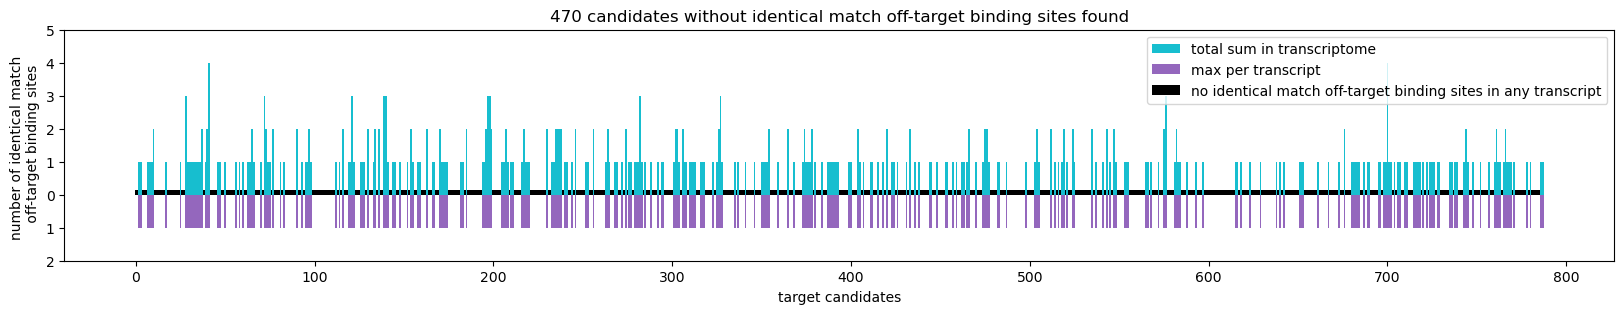

1nt mismatch sum


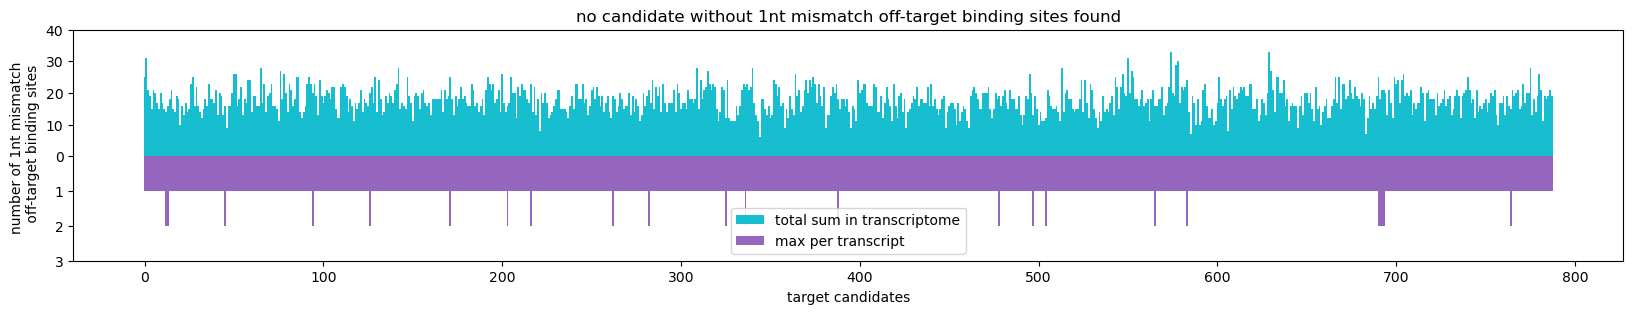

2nt mismatch sum


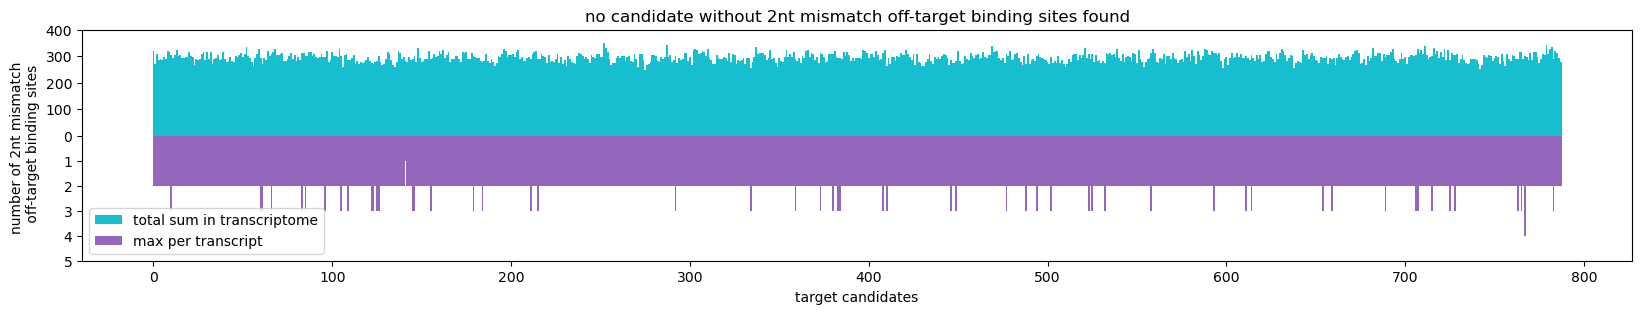

boltzmann factor sum r2t


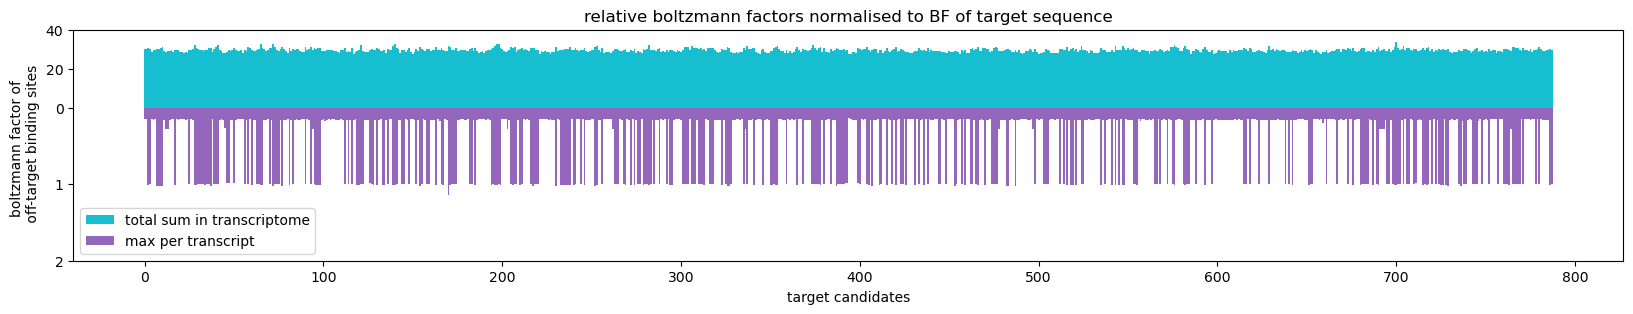

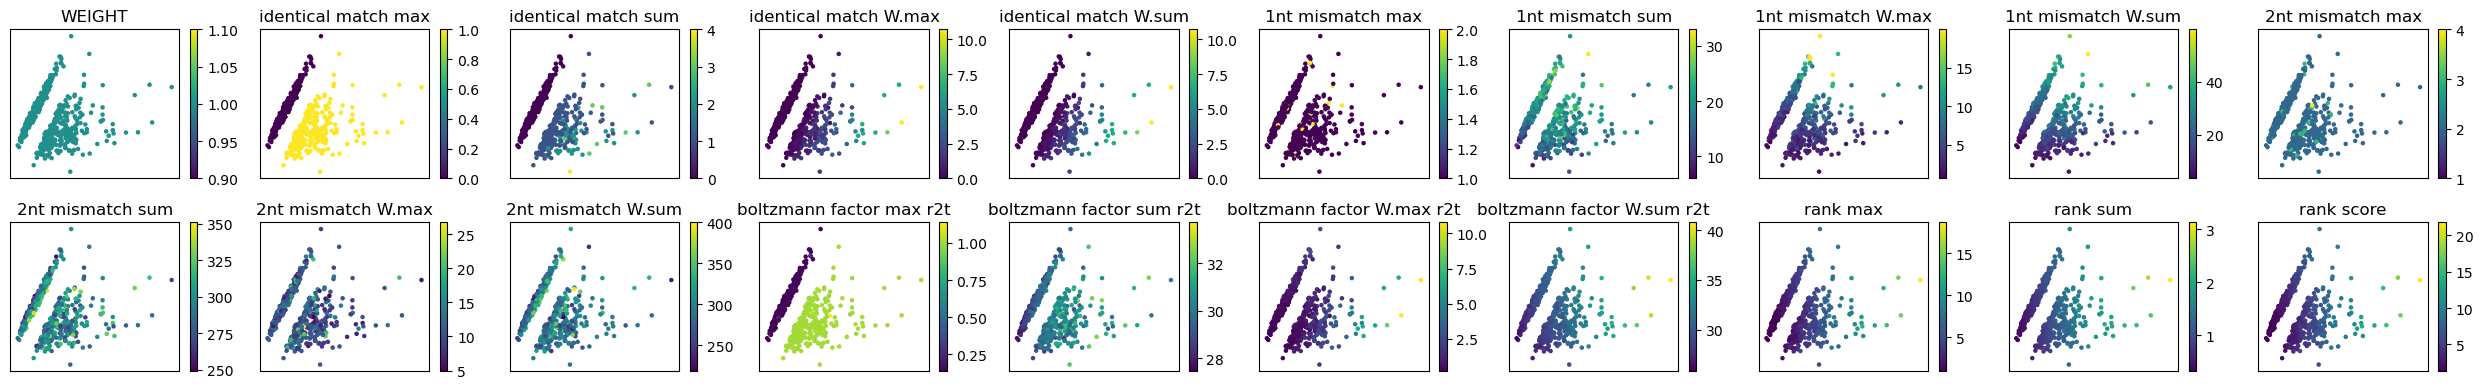

,SEQ_NAME,SEQUENCE,WEIGHT,identical match max,identical match sum,identical match VIR,identical match W.max,identical match W.sum,identical match W.VIR,1nt mismatch max,...,2nt mismatch W.VIR,boltzmann factor max r2t,boltzmann factor sum r2t,boltzmann factor VIR,boltzmann factor W.max r2t,boltzmann factor W.sum r2t,boltzmann factor W.VIR,rank max,rank sum,rank score
0,random_target_000:012,CTCTCTCTCCAG,1,0.0,0.0,[],0.000000,0.000000,[],1.0,...,"[random_transcript_#3847, random_transcript_#2...",0.144561,30.353478,"[random_transcript_#0315, random_transcript_#5...",0.490007,30.598807,"[random_transcript_#5243, random_transcript_#5...",3.979776,0.949805,4.929581
1,random_target_001:013,TCTCTCTCCAGG,1,0.0,0.0,[],0.000000,0.000000,[],1.0,...,"[random_transcript_#0122, random_transcript_#3...",0.141446,30.249862,"[random_transcript_#4382, random_transcript_#1...",0.914057,31.524809,"[random_transcript_#1634, random_transcript_#2...",5.222424,1.143392,6.365816
2,random_target_002:014,CTCTCTCCAGGA,1,1.0,1.0,[random_transcript_#4311],0.131707,0.131707,[random_transcript_#4311],1.0,...,"[random_transcript_#3847, random_transcript_#2...",1.001845,30.710816,"[random_transcript_#4311, random_transcript_#1...",0.897207,28.495907,"[random_transcript_#1634, random_transcript_#4...",2.791982,0.996016,3.787998
3,random_target_003:015,TCTCTCCAGGAA,1,1.0,1.0,[random_transcript_#2886],1.053659,1.053659,[random_transcript_#2886],1.0,...,"[random_transcript_#4538, random_transcript_#1...",1.001255,30.247342,"[random_transcript_#2886, random_transcript_#5...",1.054981,28.641000,"[random_transcript_#2886, random_transcript_#5...",3.260837,0.929685,4.190522
4,random_target_004:016,CTCTCCAGGAAA,1,0.0,0.0,[],0.000000,0.000000,[],1.0,...,"[random_transcript_#0420, random_transcript_#1...",0.142693,28.686502,"[random_transcript_#6843, random_transcript_#1...",0.341470,27.857409,"[random_transcript_#2740, random_transcript_#4...",0.975889,0.474759,1.450648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,random_target_783:795,GGAACAAGGTCG,1,0.0,0.0,[],0.000000,0.000000,[],1.0,...,"[random_transcript_#6466, random_transcript_#3...",0.157815,29.198266,"[random_transcript_#4774, random_transcript_#2...",0.491732,29.060787,"[random_transcript_#6987, random_transcript_#6...",1.825750,0.692650,2.518400
784,random_target_784:796,GAACAAGGTCGA,1,0.0,0.0,[],0.000000,0.000000,[],1.0,...,"[random_transcript_#6312, random_transcript_#6...",0.157792,29.446546,"[random_transcript_#0744, random_transcript_#4...",1.833895,30.199524,"[random_transcript_#6466, random_transcript_#3...",5.346815,1.103066,6.449881
785,random_target_785:797,AACAAGGTCGAG,1,0.0,0.0,[],0.000000,0.000000,[],1.0,...,"[random_transcript_#6466, random_transcript_#6...",0.155402,29.445607,"[random_transcript_#3298, random_transcript_#5...",0.349539,29.561350,"[random_transcript_#6063, random_transcript_#0...",2.383396,0.723215,3.106612
786,random_target_786:798,ACAAGGTCGAGG,1,1.0,1.0,[random_transcript_#4762],0.609756,0.609756,[random_transcript_#4762],1.0,...,"[random_transcript_#6466, random_transcript_#1...",1.002780,30.232033,"[random_transcript_#4762, random_transcript_#6...",0.611451,29.102974,"[random_transcript_#4762, random_transcript_#6...",2.411144,0.937327,3.348471


In [7]:
import ast
for col in [col for col in DF.columns if "VIR" in col]:
    try: DF[col] = DF[col].apply(ast.literal_eval) 
    except: pass  

weighted_rank = ((((DF.select_dtypes(np.number).rank() + 1)/(len(DF)+2)).apply(stats.norm.ppf)+2*((DF.select_dtypes(np.number).rank(method = "dense")) + 1)/(len(DF)+2)).apply(stats.norm.ppf) * DF.select_dtypes(np.number).apply(col_weight))
ranks = (DF.select_dtypes(np.number).rank() + DF.select_dtypes(np.number).rank(method = "dense"))/ (2*len(DF) +1)
weighted_ranks = 2**(ranks.apply(stats.norm.ppf)) * DF.select_dtypes(np.number).apply(col_weight)

DF["rank max"] = weighted_ranks.max(axis = 1) 
DF["rank sum"] = weighted_ranks.mean(axis = 1)  
DF["rank score"] = DF["rank max"] +  DF["rank sum"]
 

show_map(filter_unweighted(DF))
show_PCA(DF)
DF

# selection

 - select low nt mismatches first
 - select for locally for each 1/n segments of target seperatly to ensure good binding site distribution
 - filter out VIR duplicates at the end.

In [8]:
# square = 17
# root = int(np.round(square**0.5))
# best = root
# for off in [i/2 if i % 2 == 0 else -(i+1)/2 for i in np.arange(root+1)]:
#     _root = root + off
#     print(off)
#     if np.abs(_root * int(np.ceil(square/_root)) - square) < np.abs(best * int(np.ceil(square/best)) - square):
#         best = _root

C:\Users\T3D\AppData\Local\Temp\ipykernel_17392\3545786029.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  selected = df.groupby('bin')['rank score'].nsmallest(nsmallest).reset_index(level=0, drop=True).index


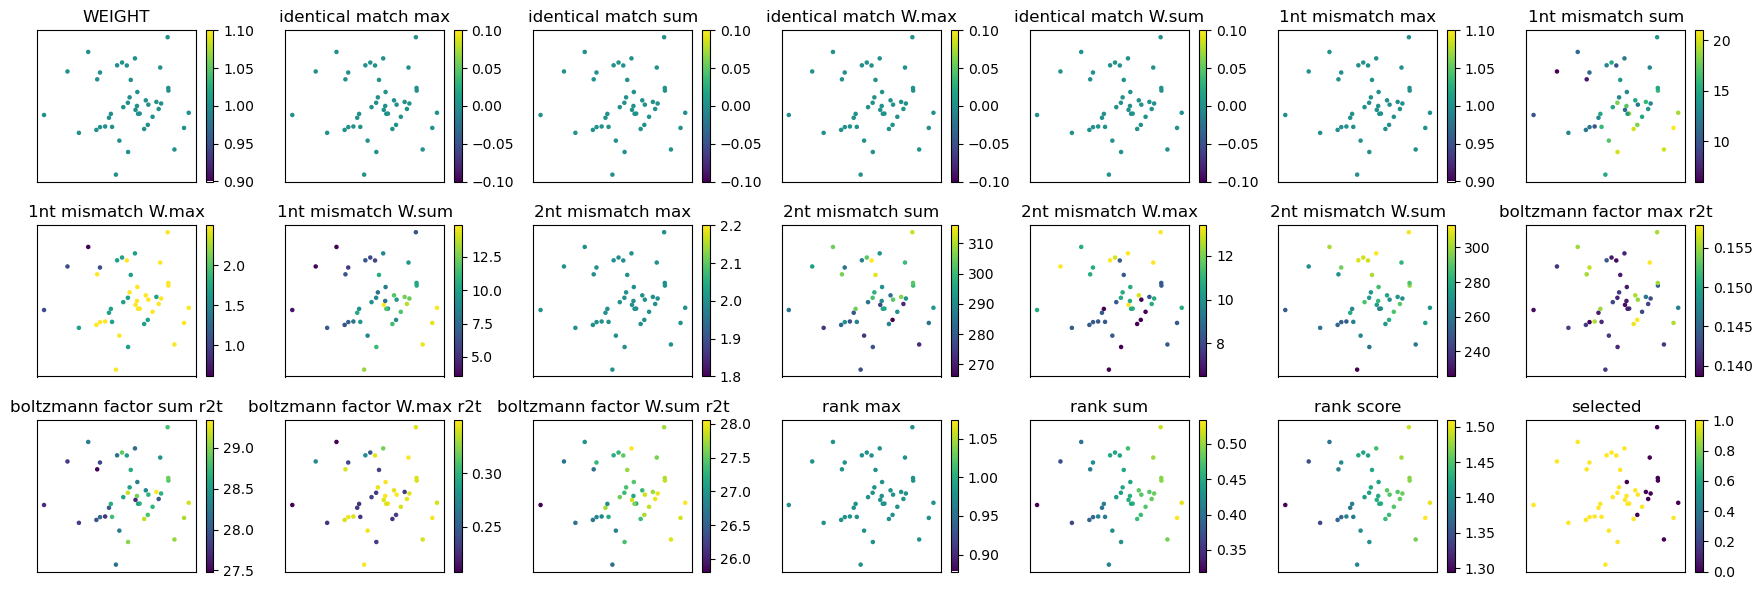

In [11]:
### Selection stage 1 ### - select evenly distributed a fixed number of samples

nbins = 6
nsmallest = 6
df = DF.copy()

max_rank = 2
min_select = nbins * nsmallest
_max = df.index.max()
for i, col in enumerate([col for col in DF.select_dtypes(np.number).columns if not "W." in col]):
    for k in range(0, max_rank+1, 1):
        sel = df[col].rank(method ='dense') <= k
        if sel.sum() >= min_select and np.histogram(df.index, bins = nbins, range = (0, _max))[0].min() > 0:
            df = df[sel]
            break

df['bin'] = pd.cut(df.index, bins=nbins)
selected = df.groupby('bin')['rank score'].nsmallest(nsmallest).reset_index(level=0, drop=True).index
df["selected"] = 0
df.loc[selected, 'selected'] = 1

show_PCA(df)

select1 = df.loc[selected]
show_df(select1, df)

In [12]:
min_select = 18
o = -1
while True:
    o += 0.001
    sel = (select1.select_dtypes('number') < (1+o)*df.select_dtypes('number').median() - o*df.select_dtypes('number').min()).sum(axis = 1 )
    if np.sum(sel == sel.max()) > min_select:
        break

sel = (select1.select_dtypes('number') < (1+o)*df.select_dtypes('number').median() - o*df.select_dtypes('number').min()).sum(axis = 1 )
select2 = select1[sel == sel.max()]
show_df(select2, df)

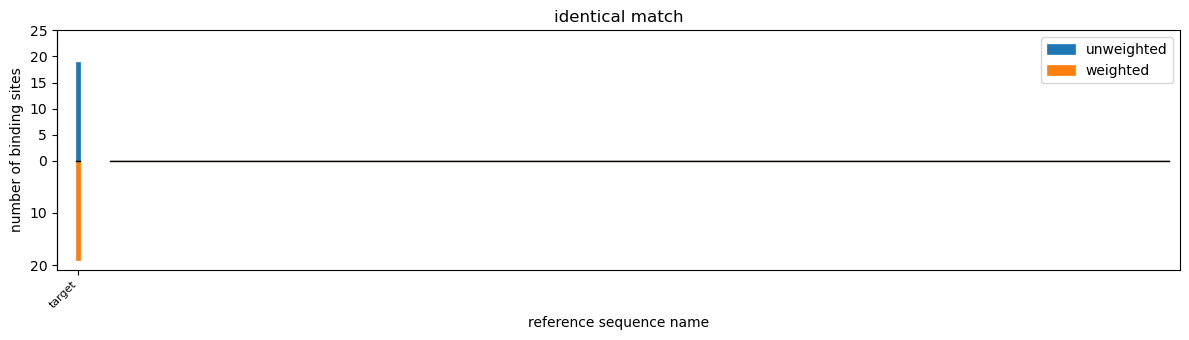

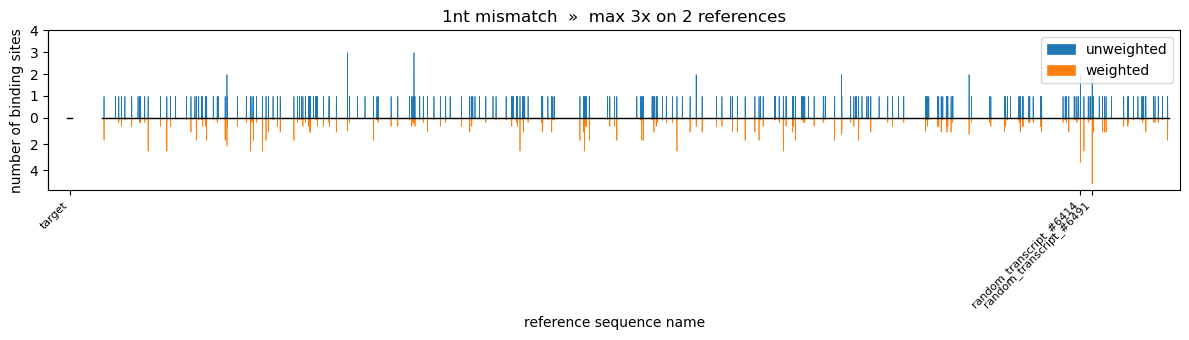

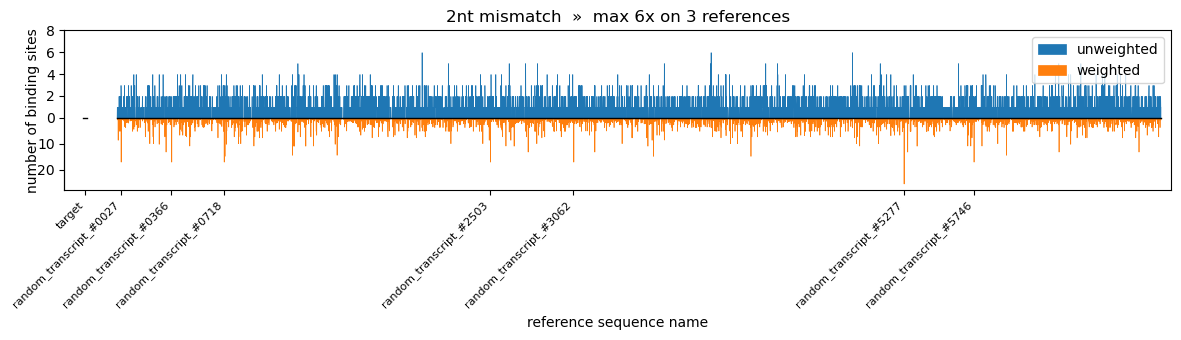

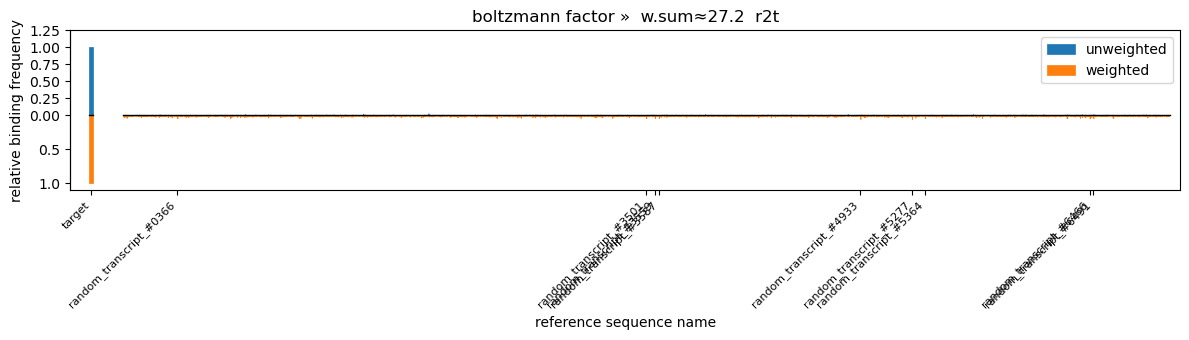

SEQ_NAME                                                      current selection
identical match max                                                         0.0
identical match sum                                                         0.0
identical match VIR                                                          []
identical match W.max                                                       0.0
identical match W.sum                                                       0.0
identical match W.VIR                                                        []
1nt mismatch max                                                            3.0
1nt mismatch sum                                                          278.0
1nt mismatch VIR              [random_transcript_#1609, random_transcript_#2...
1nt mismatch W.max                                                     4.995122
1nt mismatch W.sum                                                   165.897561
1nt mismatch W.VIR            [random_tr

In [23]:
sc_refs = pd.concat([pd.DataFrame([target]), reference_dataset], axis = 0)  # include target in sequence comparison
sc_results = list(Parallel(n_jobs=-1)(delayed(query_sc)(query, sc_refs) for _, query in select2.iterrows()))
metrics = ["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]
for i, scr in enumerate(sc_results):
    if i == 0:
        references_scr = scr.loc[~(scr.SEQ_NAME == target.SEQ_NAME)].reset_index(drop = True)  # results from the comparison with the reference dataset (sequences to avoid)
        target_scr     = scr.loc[  scr.SEQ_NAME == target.SEQ_NAME ].reset_index(drop = True).iloc[0]  # results from the comparison with the target sequence
    else:
        references_scr[metrics] += scr.loc[~(scr.SEQ_NAME == target.SEQ_NAME)].reset_index(drop = True)[metrics]  # results from the comparison with the reference dataset (sequences to avoid)
        target_scr[metrics]     += scr.loc[  scr.SEQ_NAME == target.SEQ_NAME ].reset_index(drop = True).iloc[0][metrics]  # results from the comparison with the target sequence

sc_summarize(pd.Series({"SEQ_NAME":"current selection"}), references_scr,  target_scr, plot = True)

In [24]:
### Selection stage 3 ### - avoid common off target sites 


sel = select2.drop([col for col in df.columns if ("2nt" in col) and ("VIR" in col)], axis = 1)
sel = sel[[col for col in sel.columns if not " VIR" in col]]

for col in [col for col in sel.columns if "W.VIR" in col]:
    while True:
        VIRs = sel[col].sum()
        u, c = np.unique(VIRs, return_counts= True)
        dups = u[c>1]
        if  len(dups) > 0:
            sel = sel.drop(sel[sel[col].apply(lambda ref_names: np.any([dup in ref_names for dup in dups]))]["rank score"].idxmax())
        else: break

while True:
    VIRs = sel[[col for col in sel.columns if "W.VIR" in col]].sum(axis = 1).apply(np.unique)
    u, c = np.unique(np.concat(VIRs.values), return_counts= True)
    dups = u[c>1]
    if  len(dups) > 0:
        sel = sel.drop(sel[VIRs.apply(lambda ref_names: np.any([dup in ref_names for dup in dups]))]["rank score"].idxmax())
    else: break

select3 = sel
display(show_df(select3, df))

print(dups)

[]


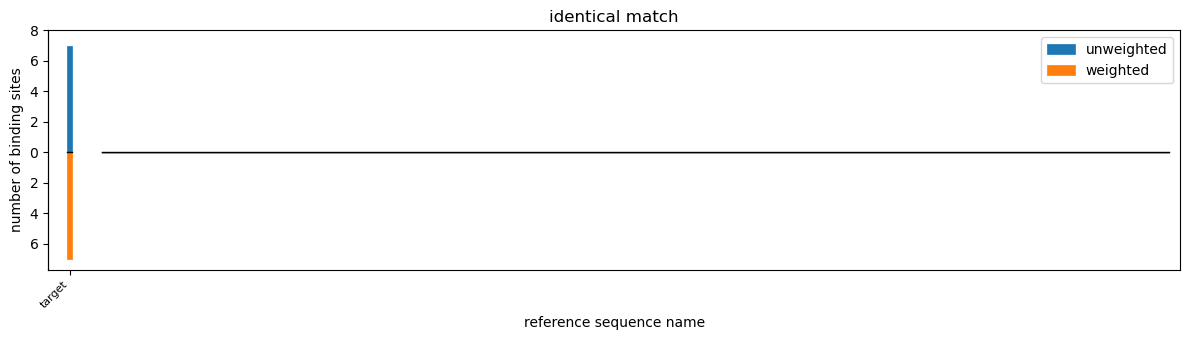

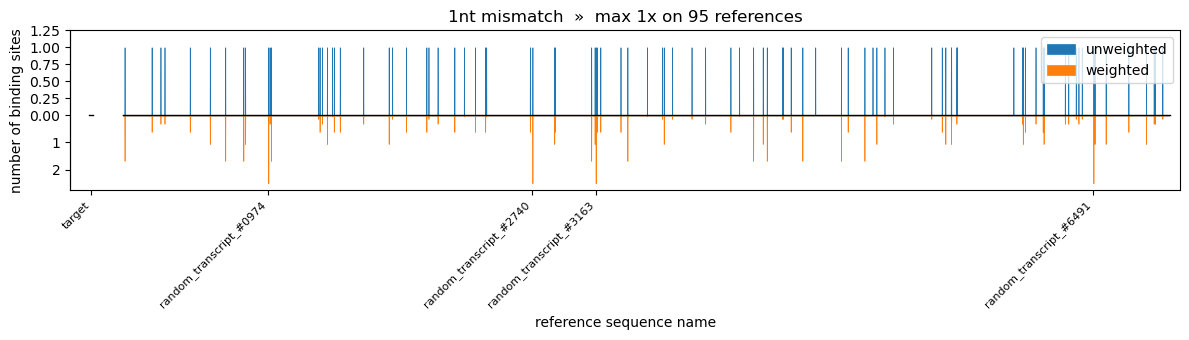

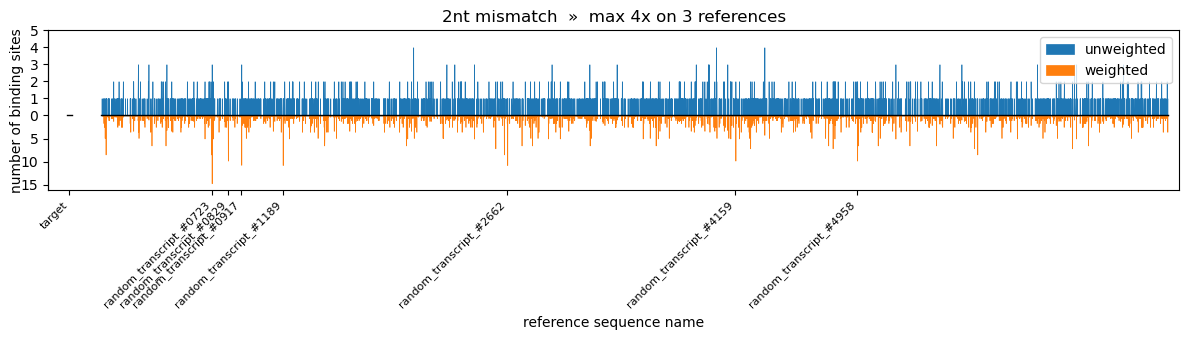

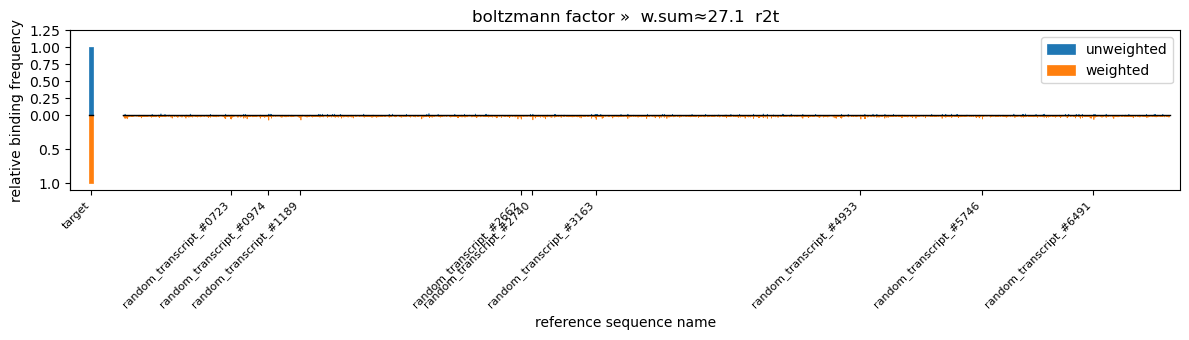

SEQ_NAME                                                      current selection
identical match max                                                         0.0
identical match sum                                                         0.0
identical match VIR                                                          []
identical match W.max                                                       0.0
identical match W.sum                                                       0.0
identical match W.VIR                                                        []
1nt mismatch max                                                            1.0
1nt mismatch sum                                                           95.0
1nt mismatch VIR              [random_transcript_#0013, random_transcript_#0...
1nt mismatch W.max                                                     2.497561
1nt mismatch W.sum                                                    66.897561
1nt mismatch W.VIR            [random_tr

In [25]:
sc_refs = pd.concat([pd.DataFrame([target]), reference_dataset], axis = 0)  # include target in sequence comparison
sc_results = list(Parallel(n_jobs=-1)(delayed(query_sc)(query, sc_refs) for _, query in select3.iterrows()))
metrics = ["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]
for i, scr in enumerate(sc_results):
    if i == 0:
        references_scr = scr.loc[~(scr.SEQ_NAME == target.SEQ_NAME)].reset_index(drop = True)  # results from the comparison with the reference dataset (sequences to avoid)
        target_scr     = scr.loc[  scr.SEQ_NAME == target.SEQ_NAME ].reset_index(drop = True).iloc[0]  # results from the comparison with the target sequence
    else:
        references_scr[metrics] += scr.loc[~(scr.SEQ_NAME == target.SEQ_NAME)].reset_index(drop = True)[metrics]  # results from the comparison with the reference dataset (sequences to avoid)
        target_scr[metrics]     += scr.loc[  scr.SEQ_NAME == target.SEQ_NAME ].reset_index(drop = True).iloc[0][metrics]  # results from the comparison with the target sequence

sc_summarize(pd.Series({"SEQ_NAME":"current selection"}), references_scr,  target_scr, plot = True)

# todo
 - combinatorial optimization of choosing n pumbys -> better than rulebased selection process
   - some way to ensure good distribution of pumbys along target
   - include the secondary structure induced binding strength
   - better model for especially the effect of multiple offtarget binding sites per transcriptom
 - documentation of new search functions
 - generalisation of visualisation functions